In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models
from kinetic.models import *
from torchdeepretina.utils import *

In [4]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

In [42]:
model.kinetics.ksr_2.data = torch.tensor([[0]]).to(device)

In [56]:
model.kinetics.ksr_2

Parameter containing:
tensor([[2.4263]], device='cuda:2', requires_grad=True)

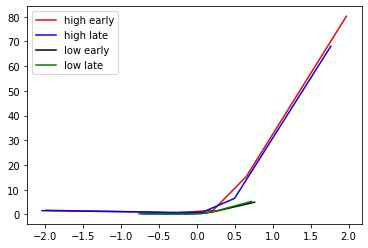

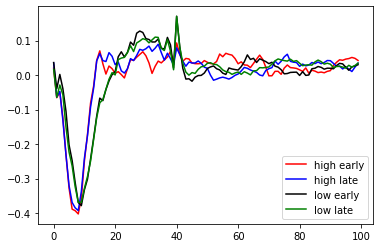

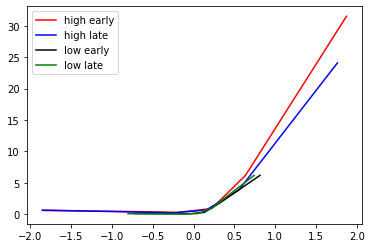

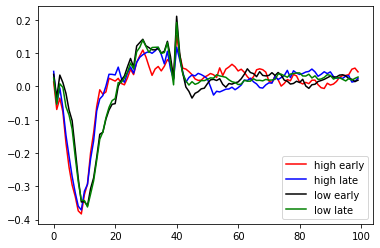

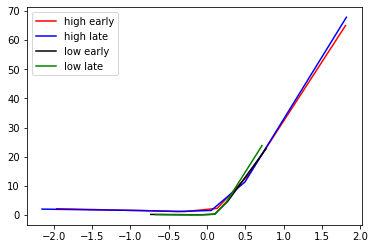

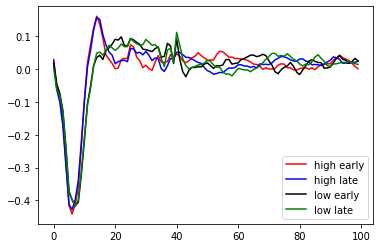

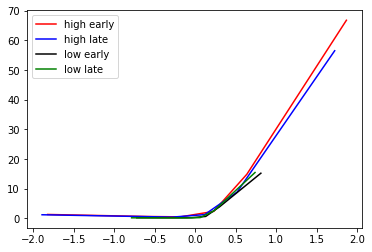

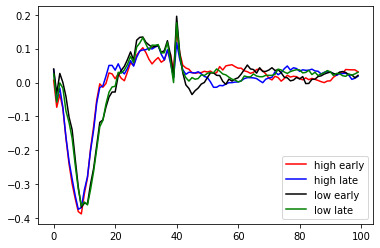

In [58]:
c0=0.2
c1=0.5
nrepeats=30
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

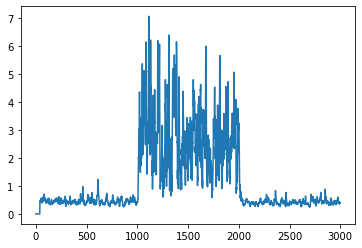

In [59]:
plt.plot(np.array(responses).mean(0)[:,0])

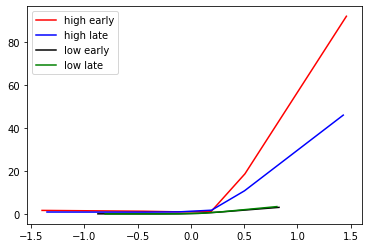

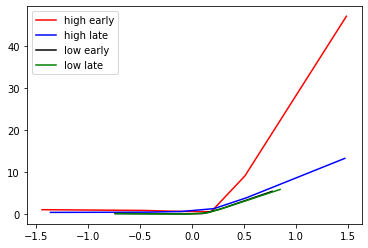

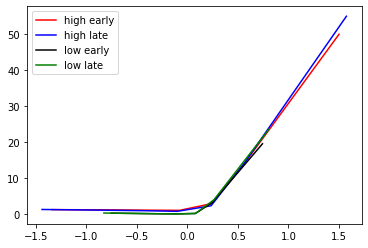

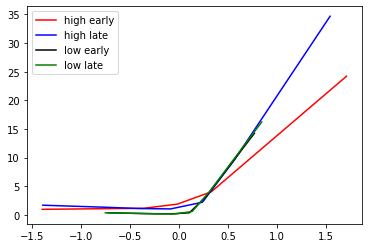

In [21]:
c0=0.2
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

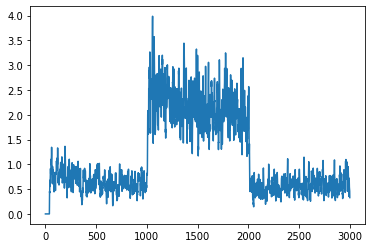

In [27]:
mean_res = np.array(responses).mean(0)
plt.plot(mean_res[:,2])

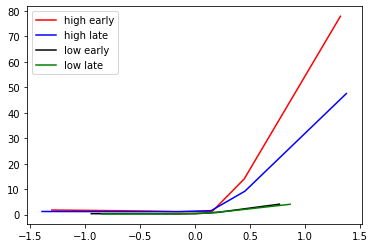

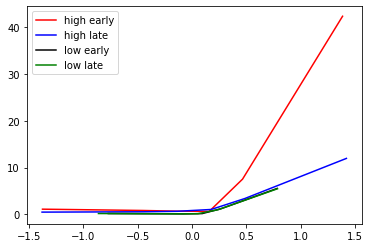

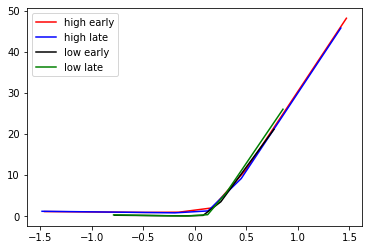

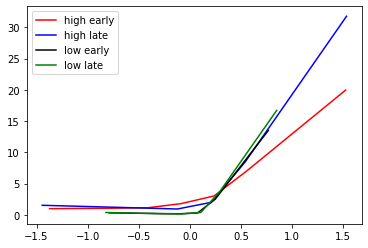

In [25]:
c0=0.2
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

In [28]:
data_kwargs = dict(cfg.Data)
train_dataset = TrainDatasetBoth(**data_kwargs)

In [29]:
train_dataset.stats

{'mean': 89.67898235010472, 'std': 43.158659388463775}

In [31]:
data_noise = loadexpt('21-01-26', 'all', 'fullfield_whitenoise', 'train', 40, 0, data_path='/home/xhding/tem_stim')

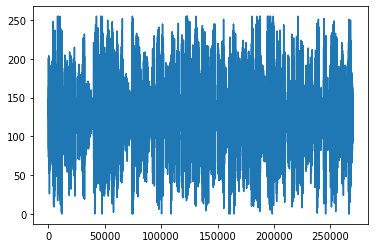

In [35]:
plt.plot(data_noise.X[:,0,0,0])

In [34]:
data_noise.X.shape

(269960, 40, 50, 50)

In [42]:
envelope = stim.flash(1000, 1000, 3000, intensity=(0.35 - 0.05))
envelope += 0.05
x = np.random.randn(*envelope.shape) * envelope

In [50]:
x = (x + 1) * 127.5

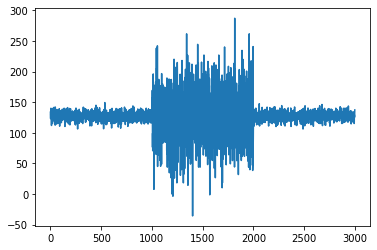

In [51]:
plt.plot(x[:,0,0])

In [52]:
x.std(), x.mean()

(25.923891847193136, 127.40111345943828)

In [25]:
fullfield_dataset = MyDataset('validation', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, cells=[1,2,7,10])

In [26]:
fullfield_dataset.stats

{'mean': 127.65495207667732, 'std': 31.9617540489452}

In [63]:
envelope = np.ones((3000, 50, 50))
envelope[:1000] = c0
envelope[1000:2000] = c1
envelope[2000:] = c0
x = np.random.randn(*envelope.shape) * envelope
x = (x + 1) * 127.5
x = (x - 89.68)/43.16
#x = (x - 127.65)/31.96
#x = (x - x.mean())/x.std()

x = torch.from_numpy(stim.rolling_window(x, 40, time_axis=0)).to(device)

In [64]:
x.shape

torch.Size([2960, 40, 50, 50])

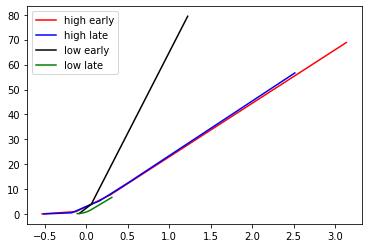

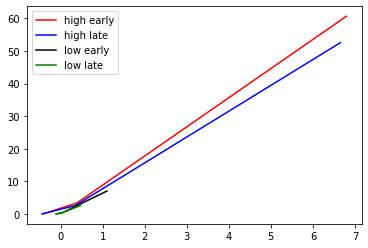

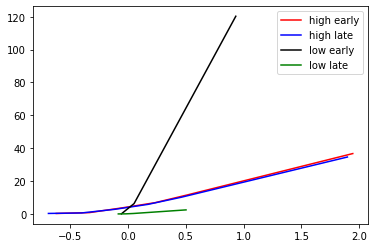

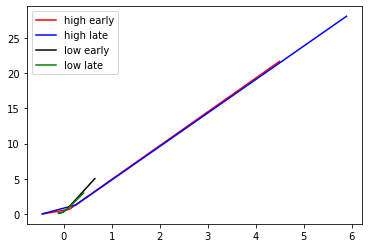

In [125]:
filt_depth = 40
nrepeats = 30
I20=None
cells='all'
duration=1000
delay=1000
nsamples=3000
hs_mode = 'single'
c0 = 0.05
c1 = 0.35

envelope = np.ones((3000, 50, 50))
envelope[:1000] = c0
envelope[1000:2000] = c1
envelope[2000:] = c0

stimuli = []
responses = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*envelope.shape) * envelope
        stimuli.append(x)
        x = (x + 1) * 127.5
        #x = (x - 89.68)/43.16
        x = (x - 127.65)/31.96
        #x = (x - x.mean())/x.std()
        
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs)
        response = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))
        responses.append(response)

if cells == 'all':
    cells = range(model.n_units)
for cell in cells:
    sta_he, x_he, nonlinear_he = LN_model_multi_trials2(stimuli, responses, c1, cell, delay, delay + 500, sta_type='revcor')
    sta_hl, x_hl, nonlinear_hl = LN_model_multi_trials2(stimuli, responses, c1, cell, delay + duration - 600, delay + duration, sta_type='revcor')
    sta_le, x_le, nonlinear_le = LN_model_multi_trials2(stimuli, responses, c0, cell, delay + duration, 
                                                     delay + duration + 500, sta_type='revcor')
    sta_ll, x_ll, nonlinear_ll = LN_model_multi_trials2(stimuli, responses, c0, cell, nsamples - 600, nsamples, sta_type='revcor')

    #sta_he, x_he, nonlinear_he = LN_model_multi_trials_fourier(stimuli, responses, c1, cell, delay, delay + 500)
    #sta_hl, x_hl, nonlinear_hl = LN_model_multi_trials_fourier(stimuli, responses, c1, cell, delay + duration - 600, delay + duration)
    #sta_le, x_le, nonlinear_le = LN_model_multi_trials_fourier(stimuli, responses, c0, cell, delay + duration, 
    #                                                      delay + duration + 500)
    #sta_ll, x_ll, nonlinear_ll = LN_model_multi_trials_fourier(stimuli, responses, c0, cell, nsamples - 600, nsamples)
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

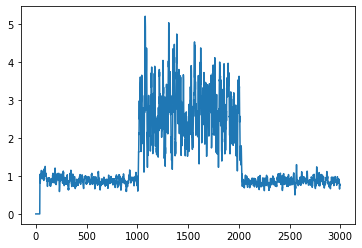

In [126]:
plt.plot(np.array(responses).mean(0)[:,0])

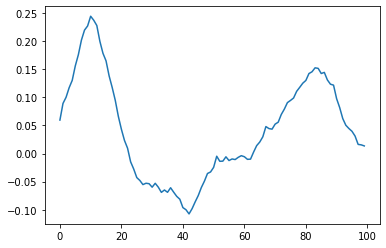

In [127]:
spatial, temporal = ft.decompose(sta_he)
plt.plot(temporal)

In [120]:
sta_he.mean()

5.3707038816241944e-21

In [82]:
stimuli[0].shape

(3000, 50, 50)

In [87]:
responses[0].shape

(3000, 4)

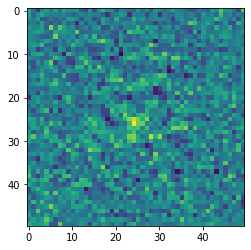

In [104]:
plt.imshow(spatial)

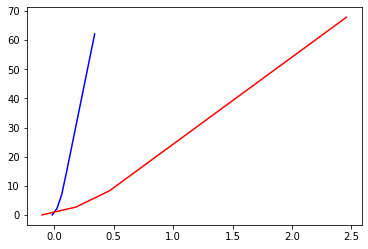

In [146]:
filt_depth = 40
nrepeats = 30
I20=None
cells='all'
hs_mode = 'single'
contrast = 0.05
filter_len = 100

cell = 0
with torch.no_grad():
    for contrast in [0.05, 0.35]:
        x = np.random.randn(1347,50,50) * contrast
        x = np.repeat(x, 3, axis=0)
        stimulus = x
        #x = (x + 1) * 127.5
        #x = (x - 89.68)/43.16
        #x = (x - 127.65)/31.96
        x = 2.37 * x

        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs)
        responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


        resp = responses[:, cell]
        sta, _ = pyret.filtertools.revcorr(stimulus, scipy.stats.zscore(resp), 0, filter_len)
        #sta, _ = pyret.filtertools.revcorr(stimulus, resp, 0, filter_len)
        sta = np.flip(sta, axis=0)
        sta -= sta.mean()

        #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
        normed_sta = normalize_filter2(sta, stimulus)

        filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
        nonlinearity = Binterp(10)
        #nonlinearity = Sigmoid(peak=100.)
        nonlinearity.fit(filtered_stim[filter_len:], resp[filter_len:])

        x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
        nonlinear_prediction = nonlinearity.predict(x)
        spatial, temporal = ft.decompose(normed_sta)

        if contrast == 0.05:
            plt.plot(x, nonlinear_prediction, 'b-')
        else:
            plt.plot(x, nonlinear_prediction, 'r-')
    plt.show()

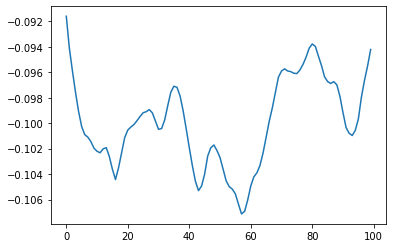

In [147]:
spatial, temporal = ft.decompose(normed_sta)
plt.plot(temporal)

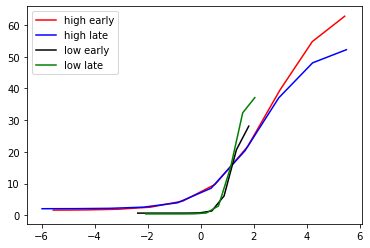

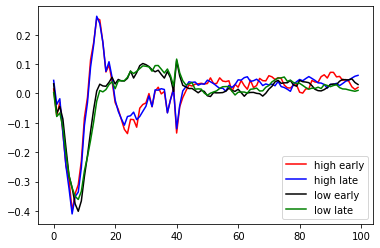

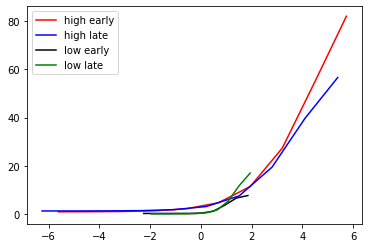

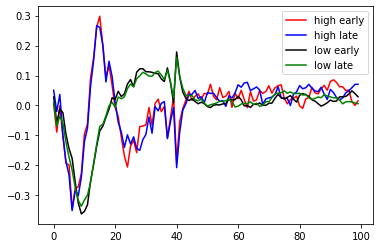

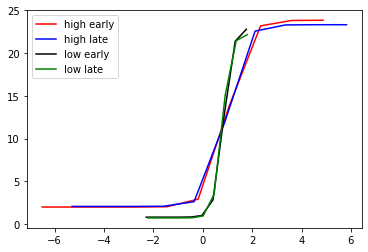

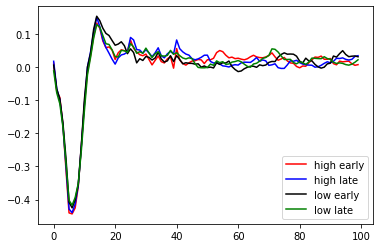

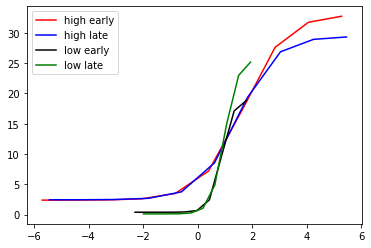

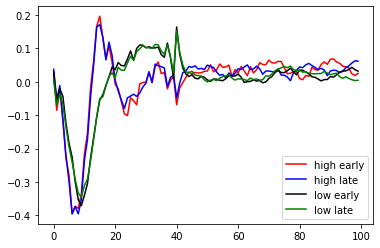

In [90]:
c0=0.5
c1=1.5
nrepeats=30
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

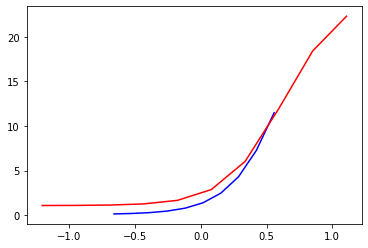

In [16]:
filt_depth = 40
I20=None
cells='all'
hs_mode = 'single'

cell = 0
for contrast in [0.2, 0.35]:
    x = np.random.randn(1347,50,50) * contrast
    x = np.repeat(x, 3, axis=0)
    stimulus = x
    x = 2.95 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    layer_outs = inspect_rnn(model, x, hs)
    responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


    resp = responses[:, cell]
    sta = compute_sta_rnn(model, contrast, layer='ganglion', cell_index=cell, verbose=False)
    sta = np.flip(sta, axis=0)
    sta -= sta.mean()

    #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
    normed_sta = normalize_filter2(sta, stimulus)

    filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
    #nonlinearity = Binterp(10)
    nonlinearity = Sigmoid(peak=100.)
    nonlinearity.fit(filtered_stim[filt_depth:], resp[filt_depth:], maxfev=5000)

    x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
    nonlinear_prediction = nonlinearity.predict(x)
    spatial, temporal = ft.decompose(normed_sta)

    if contrast == 0.2:
        plt.plot(x, nonlinear_prediction, 'b-')
    else:
        plt.plot(x, nonlinear_prediction, 'r-')
plt.show()

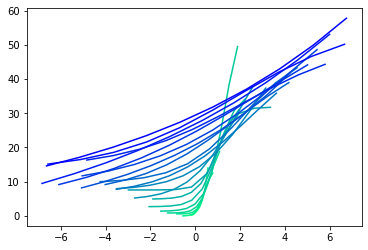

In [22]:
filt_depth = 40
I20=None
cells='all'
hs_mode = 'single'
cell = 0

cmap = plt.cm.get_cmap('winter')
colors = cmap(np.linspace(0, 1, 20))[::-1]

for idx, contrast in enumerate(np.linspace(0.05, 2., 20)):
    x = np.random.randn(1347,50,50) * contrast
    x = np.repeat(x, 3, axis=0)
    stimulus = x
    x = 2.95 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    layer_outs = inspect_rnn(model, x, hs)
    responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


    resp = responses[:, cell]
    sta = compute_sta_rnn(model, contrast, layer='ganglion', cell_index=cell, verbose=False)
    sta = np.flip(sta, axis=0)
    sta -= sta.mean()

    #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
    normed_sta = normalize_filter2(sta, stimulus)

    filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
    #nonlinearity = Binterp(10)
    nonlinearity = Sigmoid(peak=100.)
    try:
        nonlinearity.fit(filtered_stim[filt_depth:], resp[filt_depth:], maxfev=5000)

        x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
        nonlinear_prediction = nonlinearity.predict(x)
        spatial, temporal = ft.decompose(normed_sta)

        plt.plot(x, nonlinear_prediction, color=colors[idx])
    except:
        pass
plt.show()

In [60]:
filt_depth = 40
nrepeats = 10
I20=None
hs_mode = 'single'
cell = 0
c0 = 0.15
c1 = 0.35

envelope = np.ones((3040, 50, 50))
envelope[:1040] = c0
envelope[1040:2040] = c1
envelope[2040:] = c0

data_list = []
for _ in range(nrepeats):
    x = np.random.randn(*envelope.shape) * envelope
    stimulus = x
    x = 2.95 * x + 0.88

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    grad, output = inspect_grad_rnn(model, x, hs, cell_idx=cell)
    segment_dict = later_early_segments(stimulus, grad, output)
    data_list.append(segment_dict)
    
filters = gradient_filter(data_list)
nonlinear = nonlinearities(data_list, filters)

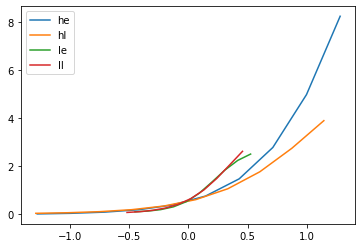

In [61]:
for key in nonlinear.keys():
    x, nonlinear_prediction = nonlinear[key]
    plt.plot(x, nonlinear_prediction, label=key)
plt.legend()
plt.show()

In [80]:
filt_depth = 40
nrepeats = 10
I20=None
hs_mode = 'single'
cell = 0
c0 = 0.5
c1 = 1.2

envelope = np.ones((3040, 1, 1))
envelope[:1040] = c0
envelope[1040:2040] = c1
envelope[2040:] = c0

data_list = []
for _ in range(nrepeats):
    x = np.random.randn(*envelope.shape) * envelope
    x = x * np.ones((envelope.shape[0], 50, 50))
    stimulus = x
    x = 2.95 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    grad, output = inspect_grad_rnn(model, x, hs, cell_idx=cell)
    segment_dict = later_early_segments(stimulus, grad, output)
    data_list.append(segment_dict)
    
filters = gradient_filter(data_list, True)
nonlinear = nonlinearities(data_list, filters)

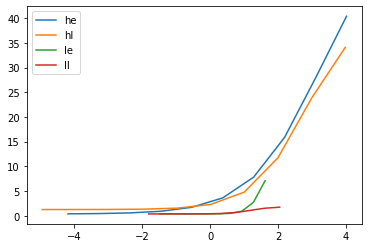

In [81]:
for key in nonlinear.keys():
    x, nonlinear_prediction = nonlinear[key]
    plt.plot(x, nonlinear_prediction, label=key)
plt.legend()
plt.show()

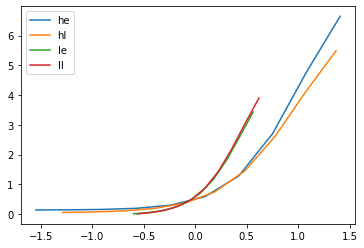

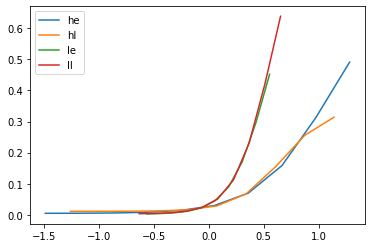

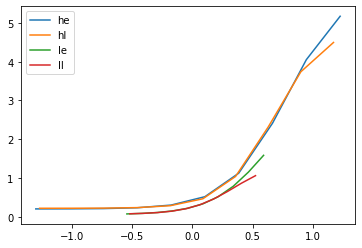

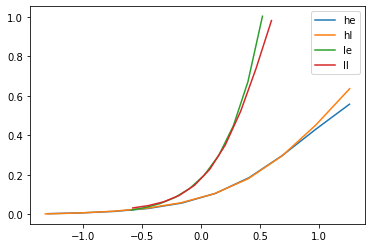

In [86]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.15, c1 = 0.35, scale=2.95, shift=0.88, stim_type='checkerboard', nrepeats=30)

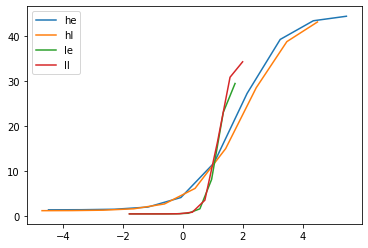

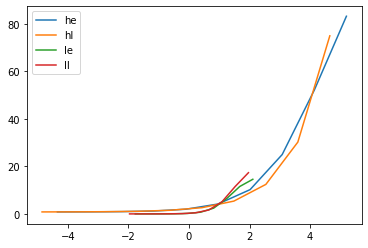

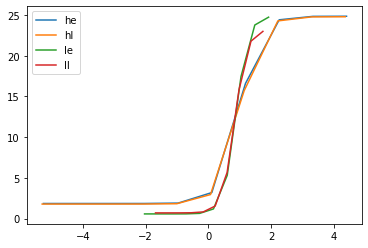

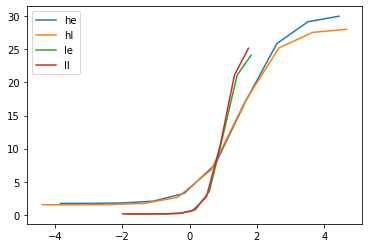

In [87]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.2, scale=2.95, shift=0., stim_type='fullfield', nrepeats=30)

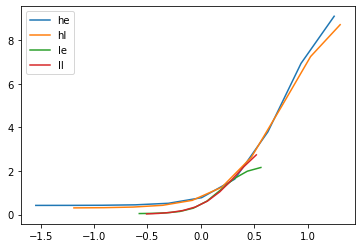

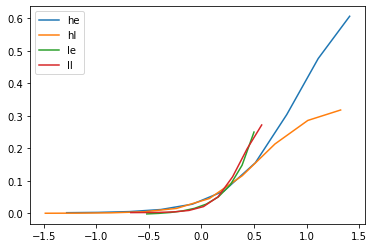

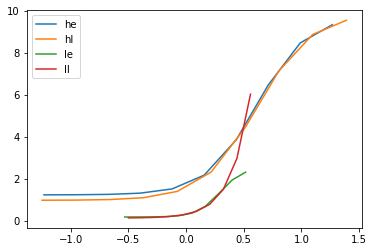

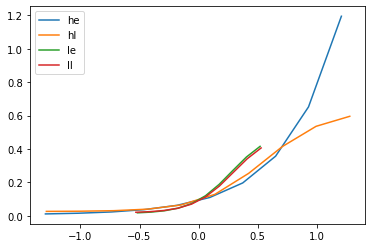

In [94]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.15, c1 = 0.35, scale=2.95, shift=0.88, stim_type='checkerboard', nrepeats=30)

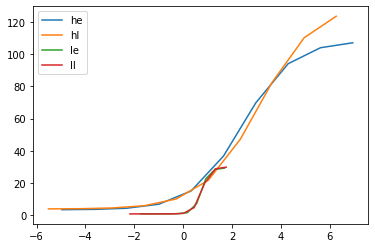

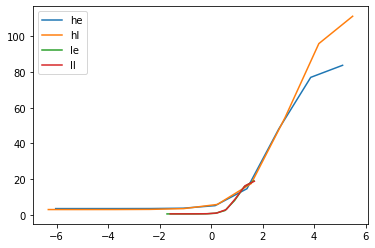

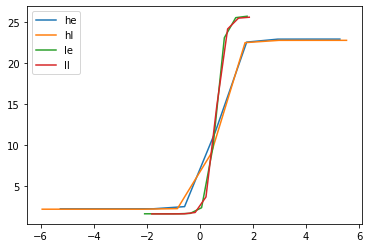

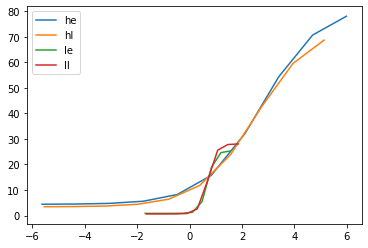

In [95]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.5, scale=2.95, shift=0., stim_type='fullfield', nrepeats=30)

In [19]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.35_pearson_natural_0.4354_pearson_noise_0.4798.pth'
#checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_008_loss_1.43_pearson_0.4901.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.43_pearson_0.4919.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

In [4]:
fullfield_dataset = MyDataset('train', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, cells=[1,2,7,10])
fullfield_dataset.stats

{'mean': 127.65495207667732, 'std': 31.9617540489452}

In [31]:
fullfield_dataset = MyDataset('train', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield_whitenoise', 30000, cells='all')
fullfield_dataset.stats

{'mean': 127.54951851851852, 'std': 28.607890356944278}

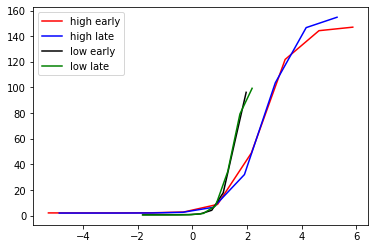

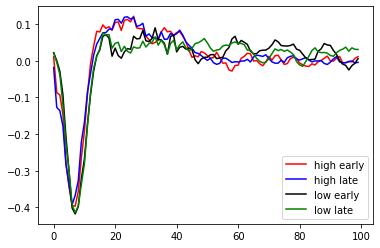

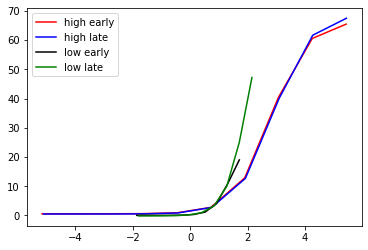

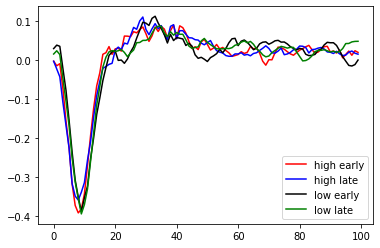

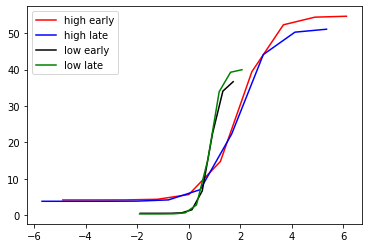

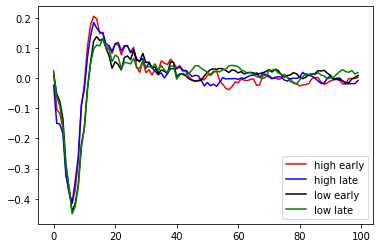

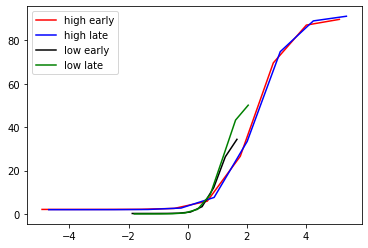

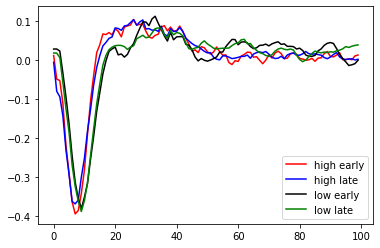

In [12]:
c0=0.5
c1=1.5
nrepeats=30
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

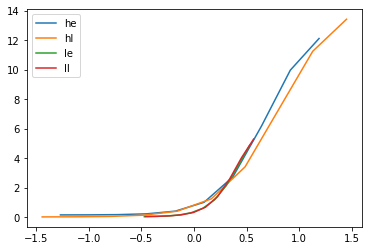

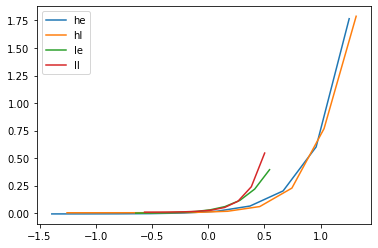

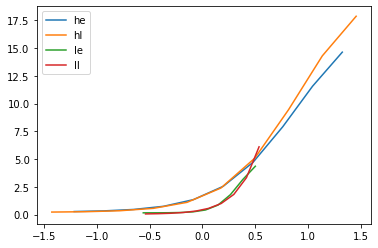

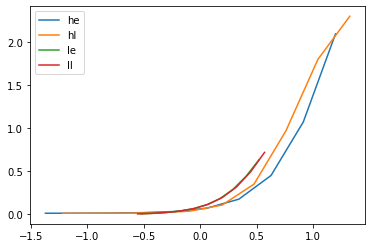

In [20]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.15, c1 = 0.35, scale=3.99, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

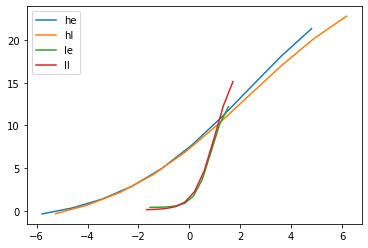

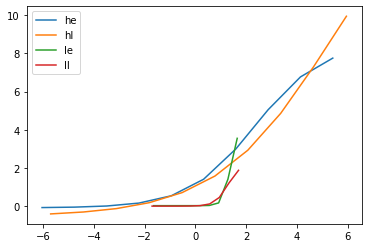

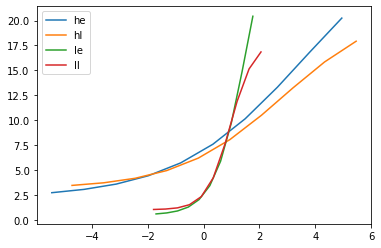

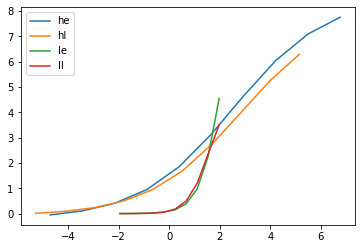

In [23]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.5, scale=3.99, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

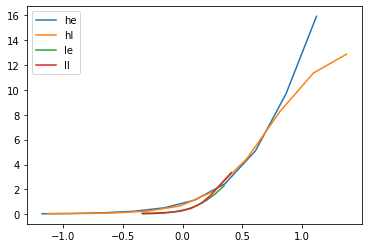

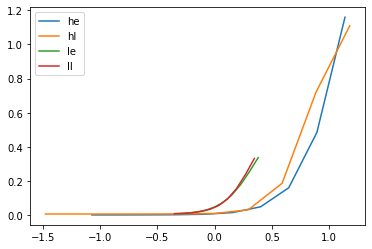

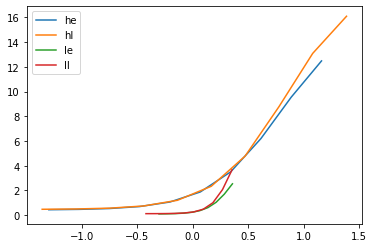

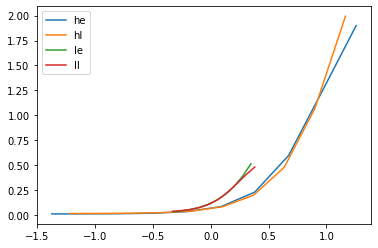

In [24]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.1, c1 = 0.35, scale=3.99, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

In [3]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.35_pearson_natural_0.4354_pearson_noise_0.4798.pth'
#checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_008_loss_1.43_pearson_0.4901.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_028_loss_1.43_pearson_0.4880.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

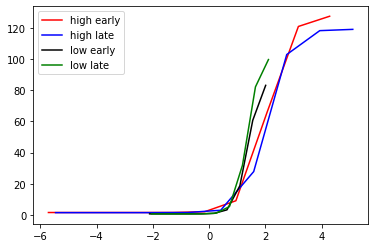

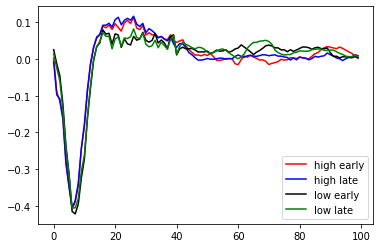

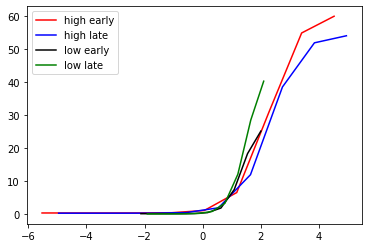

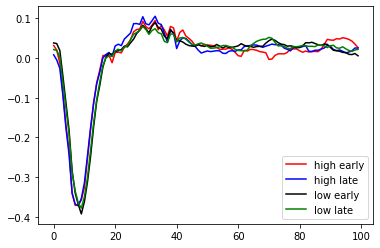

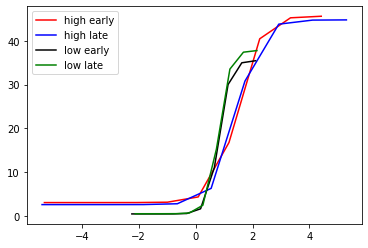

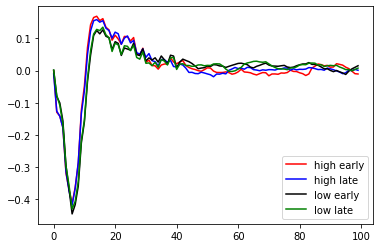

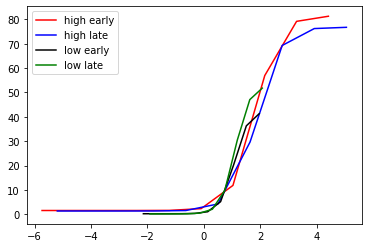

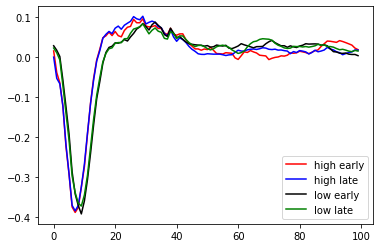

In [33]:
c0=0.5
c1=1.2
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

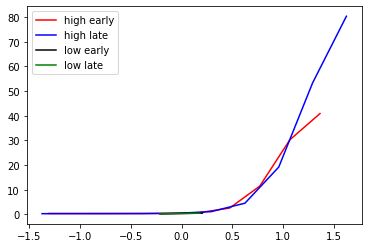

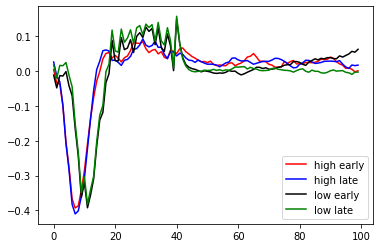

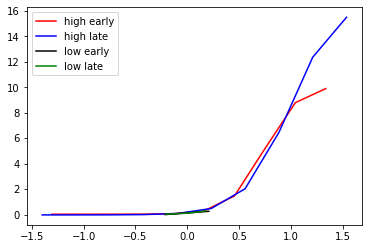

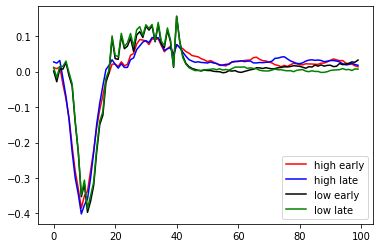

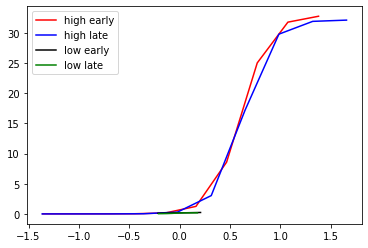

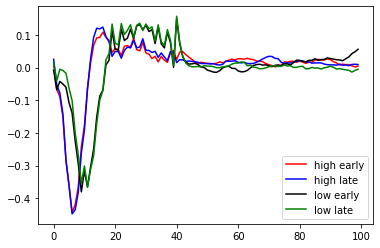

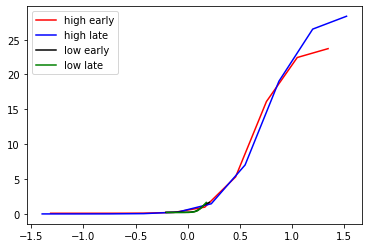

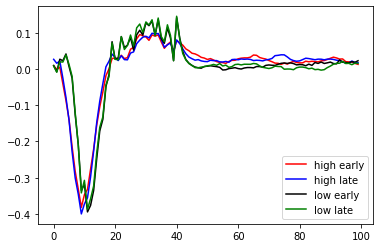

In [35]:
c0=0.05
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

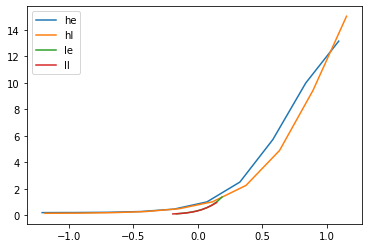

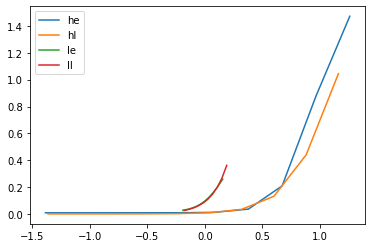

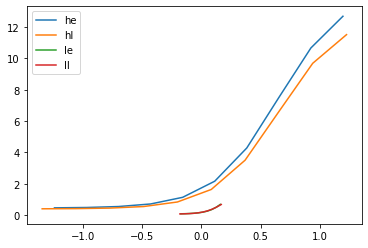

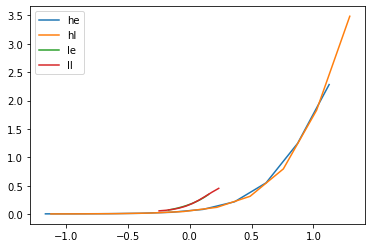

In [34]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.05, c1 = 0.35, scale=4.46, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

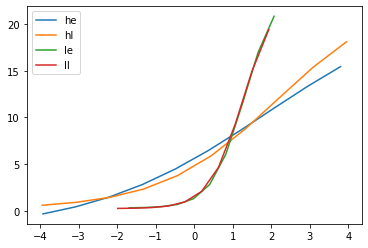

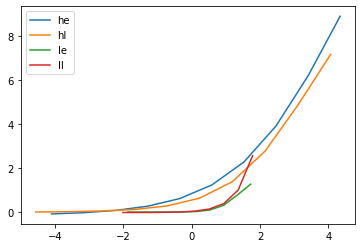

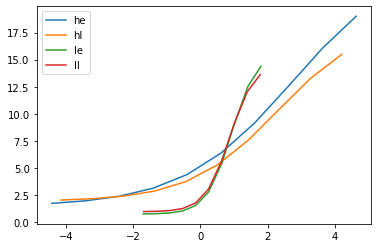

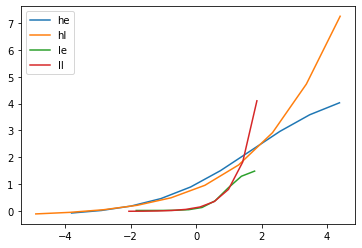

In [5]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.2, scale=4.46, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

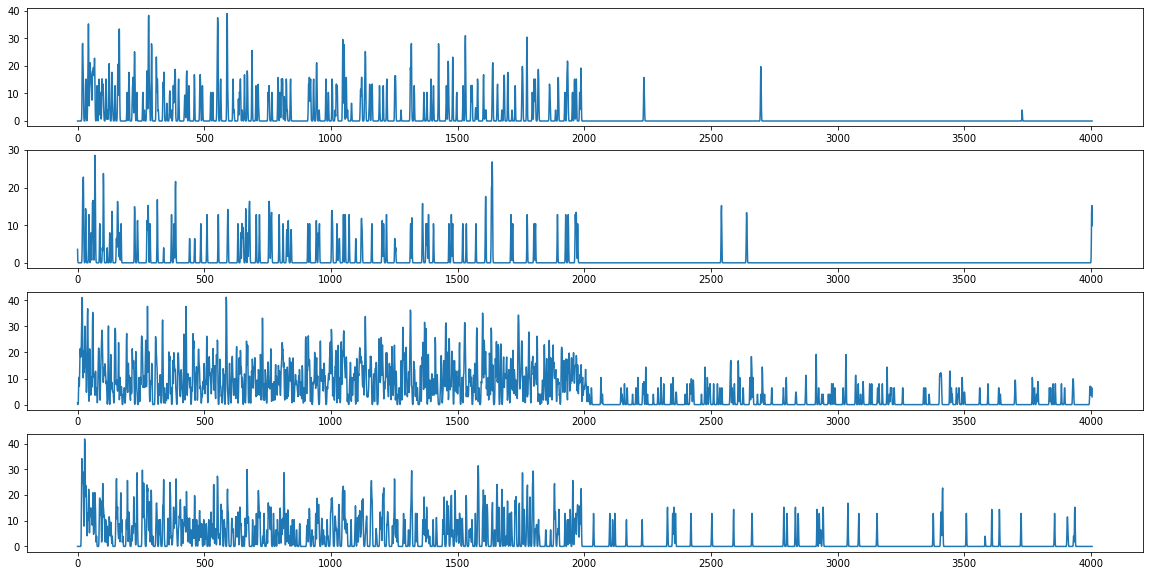

In [6]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])
stimuli = stimulus[:40060].reshape((10,-1))
responses = np.swapaxes(resp, 0, 1)[:40060].reshape((10, -1, 11))
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i, cell in enumerate([1,2,7,10]):
    ax[i].plot(responses.mean(0)[:, cell])
plt.show()

In [10]:
stats = {'mean': 127.54951851851852, 'std': 28.607890356944278}
fullfield_dataset = MyDataset('validation', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, stats=stats, cells=[1,2,7,10])
fullfield_data =  DataLoader(fullfield_dataset)
pearson, val_pred, val_targ = pearsonr_eval(model, fullfield_data, 4, device, with_responses=True)

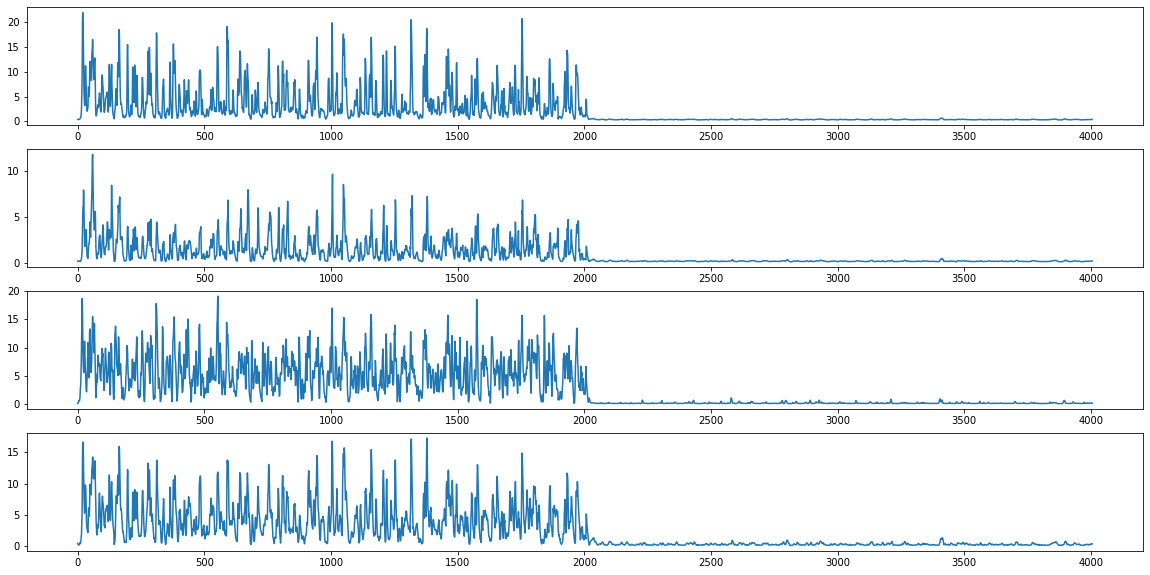

In [13]:
responses = val_pred[3966:40020, :].reshape((9, -1, 4))
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i in range(4):
    ax[i].plot(responses.mean(0)[:, i])
plt.show()

In [12]:
pearson

0.5317367463596985

In [16]:
((val_pred - val_targ)**2).mean()

159.87417833040823

In [33]:
((1.2*val_pred - val_targ)**2).mean()

157.81463201071438

In [43]:
(1.42*val_pred - val_targ).mean()

4.4309820541389784e-05

In [58]:
np.abs(0*val_pred - val_targ).mean()

3.058164845516696

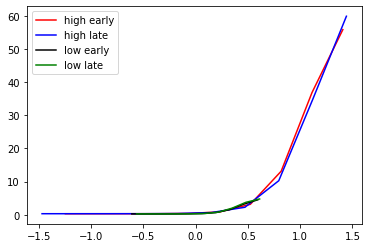

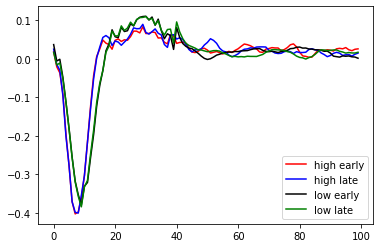

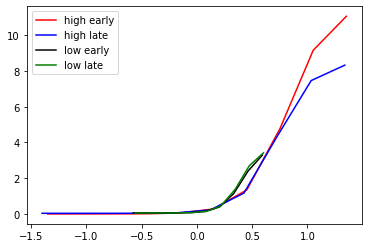

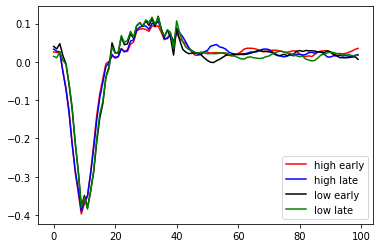

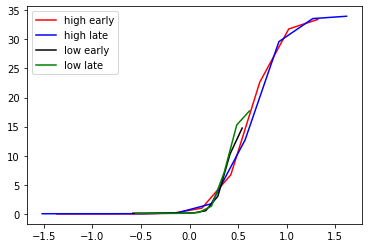

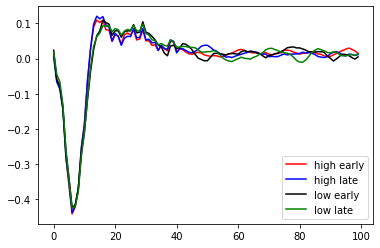

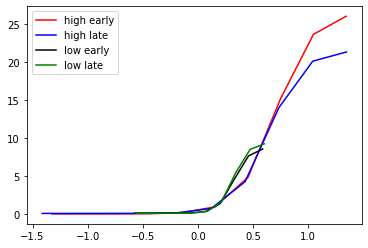

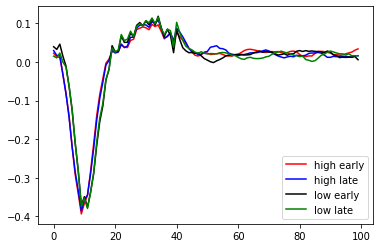

In [59]:
c0=0.15
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

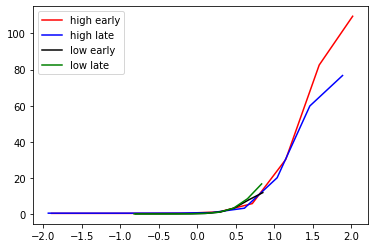

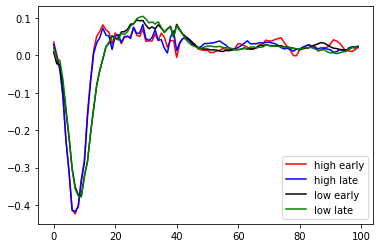

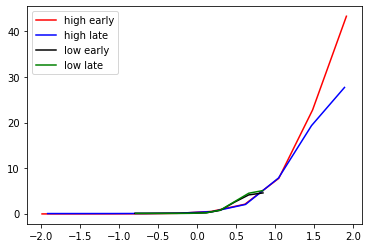

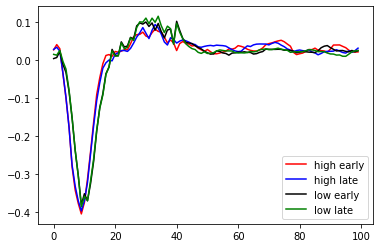

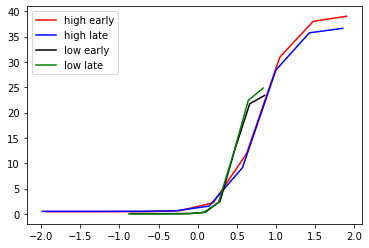

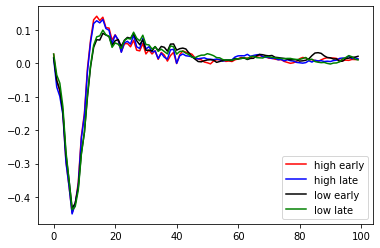

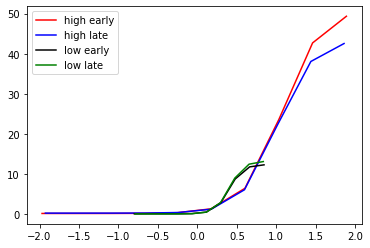

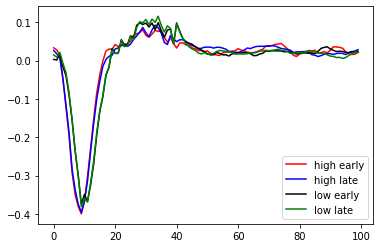

In [62]:
c0=0.2
c1=0.5
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)